In [1]:
#######################
###     IMPORTS     ###
#######################

import http.client
import pandas as pd 
import json
import collections
from collections import Counter
import math

# Create Connection
conn = http.client.HTTPSConnection("v1.formula-1.api-sports.io")

headers = {
    'x-rapidapi-host': "v1.formula-1.api-sports.io",
    'x-rapidapi-key': "5cf553b6b73d7130cdb6bc81975c2510"
}

In [2]:
#########################
###     FUNCTIONS     ###
#########################
 
# This function gets the f1 race data, returns it as json (see below cell on how to make it a dataframe/csv file)
# endpoint is what type of data you want, for example rankings/drivers, params are any parameters needed
# refer to api-sports documentation for how to query data
def f1_data(endpoint, params):
    conn.request("GET", f"/{endpoint}?{params}", headers=headers)
    response = conn.getresponse()
    data = response.read()
    json_data = json.loads(data.decode("utf-8"))
    return json_data

In [3]:
# REQUEST DATA
races = f1_data("rankings/drivers", "season=2021")
all_races = races['response']
races_df = pd.DataFrame(all_races)

# TO CSV FILE
races_df.to_csv('races_2021.csv', index=False)

SSLCertVerificationError: [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1006)

In [ ]:
# ENTROPY FUNCTION
def entropy(classifications):
    '''
    Calculate the entropy of an attribute. Takes a list of classifications in the form of: 
    [1, 4, 3, 5, 5, 3, 2, 1, 7] where each element represents the classification
    Works on string classifications too, Ex. ['Top 10', 'Win', 'Top 3']

    Rounded to four decimal points

    list -> float
    '''
    freq = collections.Counter(classifications)
    denom = len(classifications)
    total = 0
    for _, value in freq.items():
        total -= (value / denom) * math.log2(value / denom)
    return round(total, 4)

# INFORMATION GAIN FUNCTION
def info_gain(classifications, parent_entropy):
    ''' 
    Calculates the information gain of an attribute. Classifications is a dictionary of attribute with 
    keys being a trait and values being the classifications. 
    Ex. Attribute = Top 10 percent fastest lap time?
        {'Yes' : [Top 5, Top 3, Top 10],
        'No' : [Top 15, Top 20, Top 10]}
    
    Parent entropy is the entropy value for the parent. Needed to calculate the information gain.
    
    The classifications dictionary should be the data of the parent node after being split by the attribute
    that the classification dictionary represents.

    Rounds to four decimal places.

    #NOTE:
    The parent entropy is just given as parameter, may need to update later to just give parent data and
    classifications.
                                                            
    dict, float -> float
    '''
    child_entropy = []
    total = 0

    for _, value in classifications.items():
        child_entropy.append((entropy(value), len(value)))
        total += len(value)

    weight_ave_entropy = 0
    for item in child_entropy:
        weight_ave_entropy += item[0] * (item[1] / total)
    
    return round(parent_entropy - weight_ave_entropy, 4)

In [ ]:
class OtherKey:
    def __repr__(self):
        return 'OTHER'
    
OTHER = OtherKey()

In [ ]:
###################################
###     DECISION TREE CLASS     ###
###################################

'''
Things to remember when implementing the decision tree

1. Take a look at the entropy and infromation gain function and specifically how they take
inputs to make sure we call the functions correctly

2. Remember we want to maximize information gain at the root, in other words minimize the 
entropy at the top of the decision tree

3. Need to be consious of how are data is going to be put into the algorithm. This goes a
little bit past the implementation for DT Class, but we need to see what data we will
ultimately decide to use. The Implementation may be tweaked a little bit to fit this.

4. We want our classifications to fall into categories of:
 ['Win', 'Top 3', 'Top 5', 'Top 10', 'Top 15', 'Top 20']
 *** This strategy may change but for know that is what we are rolling with ***
'''

# A node in a decision tree
class Node:
    def __init__(self, attribute=None, children=None, classification=None):
        '''
        Intializer function
        Takes an attribute for the node, a dictionary of children nodes and a classification
        If it is a leaf node (no children) it will have a classification else None
        '''
        self.attribute = attribute
        self.classification = classification
        if children is None:
            self.children = {}
        else:
            self.children = children

        def __repr__(self):
            if self.classification is not None:
                return f'Node(classification={self.classification!r})'
            if self.attribute is not None:
                child_reprs = {val: repr(child).replace('\n','\n    ') for val, child in self.children.items()}
                repr_string = f'Node(attribute={self.attribute!r}, children={{\n'
                for val, rep in child_reprs.items():
                    repr_string += f'    {val!r}: {rep},\n'
                repr_string += '  })'
                return repr_string
            return 'Node()'

    def classify(self, point):
        '''
        A function used to classify a point. Recursively calls until we reach a classification.
        Taken from a5.

        dict -> classification
        '''
        if self.classification is not None:
            return self.classification
        

        val = point.get(self.attribute)
        child = self.children.get(val)

        if child is None:
            child = self.children.get(OTHER)

        return child.classify(point)
        

    def train(self, points, labels, depth=0, max_depth=20):
        '''
        A function used to train the decision tree,
        need to get code from a5 and make sure it fits the constraints that we have for the problem
        '''
        
        # if all the labels are the same make a leaf
        if len(set(labels)) == 1:
            self.classification = labels[0]
            return
        
        # recurring too deep
        if depth >= max_depth:
            self.classification = Counter(labels).most_common(1)[0][0]
            return
        
        best_attribute = None
        best_ig = float('-inf')
        best_split = None

        attributes = points[0].keys()

        for attr in attributes:
            value_counts = {}
            split_points = {}
            split_labels = {}

            for point, label in zip(points, labels):
                val = point[attr]
                if val not in value_counts:
                    value_counts[val] = 0
                    split_points[val] = []
                    split_labels[val] = []
                value_counts[val] += 1
                split_points[val].append(point)
                split_labels[val].append(label)

            least_val = min(value_counts, key=value_counts.get)
            other_points = split_points.pop(least_val)
            other_labels = split_labels.pop(least_val)

            split_points[OTHER] = other_points
            split_labels[OTHER] = other_labels
            value_counts[OTHER] = value_counts.pop(least_val)

            parent_entropy = entropy(labels)
            ig = info_gain(split_labels, parent_entropy)
        
            if ig > best_ig:
                best_ig = ig
                best_attribute = attr
                best_split = (split_points, split_labels)
        if best_attribute is None:
            self.classification = Counter(labels).most_common(1)[0][0]
            return

        self.attribute = best_attribute
        for val in best_split[0]:
            child = Node()
            child.train(best_split[0][val], best_split[1][val], depth=depth+1, max_depth=max_depth)
            self.children[val] = child

In [ ]:
###############################
###   CLEANING TRAIN DATA   ###
###############################

'''
These are the classifications we are going to use:
1 - First
3 - Top 3
5 - Top 5
10 - Top 10
-1 - Outside Top 10
'''

classifications = [1, 3, 5, 10, -1]

'''
Cleaning the data that we will use to train and putting it into our 
data dictionary (data_dict).

We need to find which features to have for each datapoint. We need to remember
that the data should be availible BEFORE the race so that we done have any bias.

Ex. We can't predict the outcome of the race based on fastest lap time, because
we don't know that before the race, and it could happen on the very last lap.

It also needs to organized in a thoughtful way. Each row (or item in our dictionary)
is a datapoint. Should we have each row be a race, and then a feature is a dict
with each driver being a key and their data is the value? Just some ideas to start.

I have an example of how you can add information to a dictionary from a dataframe
below.
'''
data_dict = {}

# getting results data
results = pd.read_csv('kaggle-data/archive/results.csv') # results data
# drop_lst = ['fastestLapSpeed', 'fastestLapTime', 'fastestLap', 'time', 'milliseconds',
#        'points', 'positionText', 'position', 'grid']
# results.drop(drop_lst, axis=1) # dropping some data
results = results[results['grid'] != 0]

for index, row in results.iterrows():
    key_tuple = (row['raceId'], row['driverId']) # tuple for key in data dictionary
    value_list = [row['raceId'], row['driverId'], row['grid']]
    
    # checking for classification
    if row['positionOrder'] == 1: # first place 
        classification = 1
    elif row['positionOrder'] <= 3: # top 3
        classification = 3
    elif row['positionOrder'] <= 5: # top 5
        classification = 5
    elif row['positionOrder'] <= 10: # top 10
        classification = 10
    else: # outside top 10
        classification = -1

    
    # get last 5 races
    driver_id = row['driverId']
    race_id = row['raceId']

    past_races = results[(results['driverId'] == driver_id) & 
                         (results['raceId'] < race_id)]

    # Sort descending so we get most recent first
    past_races = past_races.sort_values(by='raceId', ascending=False)

    past_positions = past_races['positionOrder'].head(5)

    if len(past_positions) == 5:
        avg_pos = past_positions.mean()
    else:
        avg_pos = None  # not enough history

    if avg_pos is not None:
        value_list.append(avg_pos)
        value_list.append(classification)

        data_dict[key_tuple] = value_list

'''
The data dictionary format is as follows:
{(raceId, driverId) : [raceId, driverId, grid, average_finish (last 5 races), classification]}

So we will have an entry for every driver in every race.
We need to add the last 5 race average and maybe historical
performance at a specific race
'''

drivers = pd.read_csv('kaggle-data/archive/drivers.csv') # driver data
drivers_dict = {}

# making a dictionary to map driverId to driver name
for index, row in drivers.iterrows():
    drivers_dict[row['driverId']] = row['driverRef']




{(18, 1): [18, 1, 1, 7.6, 1], (18, 2): [18, 2, 5, 10.8, 3], (18, 3): [18, 3, 7, 11.4, 3], (18, 4): [18, 4, 11, 10.4, 5], (18, 5): [18, 5, 3, 8.8, 5], (18, 6): [18, 6, 13, 12.4, 10], (18, 7): [18, 7, 17, 16.8, 10], (18, 8): [18, 8, 15, 7.0, 10], (18, 9): [18, 9, 2, 9.6, 10], (18, 10): [18, 10, 18, 11.4, 10], (18, 12): [18, 12, 20, 14.4, -1], (18, 13): [18, 13, 4, 4.6, -1], (18, 15): [18, 15, 6, 10.8, -1], (18, 16): [18, 16, 22, 14.0, -1], (18, 17): [18, 17, 14, 11.4, -1], (18, 18): [18, 18, 12, 4.6, -1], (18, 20): [18, 20, 9, 3.6, -1], (18, 21): [18, 21, 16, 12.2, -1], (18, 22): [18, 22, 10, 5.2, -1], (19, 8): [19, 8, 2, 8.0, 1], (19, 9): [19, 9, 4, 7.6, 3], (19, 5): [19, 5, 8, 8.6, 3], (19, 15): [19, 15, 3, 11.0, 5], (19, 1): [19, 1, 9, 5.4, 5], (19, 2): [19, 2, 5, 9.8, 10], (19, 17): [19, 17, 6, 10.8, 10], (19, 4): [19, 4, 7, 10.2, 10], (19, 18): [19, 18, 11, 7.8, 10], (19, 12): [19, 12, 13, 13.0, -1], (19, 21): [19, 21, 17, 14.6, -1], (19, 22): [19, 22, 14, 9.4, -1], (19, 3): [19, 3,

In [ ]:
####################
###   TRAINING   ###
####################

# this is not working for now

points = []
labels = []

# I am going to change this later to only run on 80 percent of the data dict, the other 20 percent will be used for testing
for key, value in data_dict.items():
    point = {
        'grid' : value[2],
        'avg_finish': value[3]
    }
    label = value[4]
    points.append(point)
    labels.append(label)

tree = Node()
tree.train(points, labels)

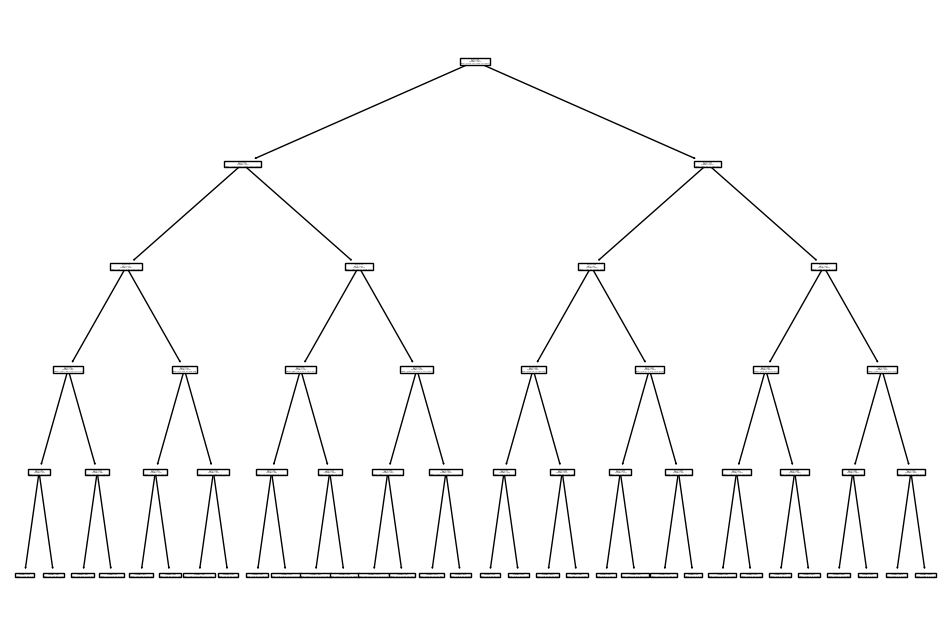

In [ ]:
###############################
###   SCIPY DECISION TREE   ###
###############################
from sklearn import tree
import matplotlib.pyplot as plt

points = []
labels = []
for key, value in data_dict.items():
    point = [value[2], value[3]]
    label = value[4]
    points.append(point)
    labels.append(label)

X, y = points, labels
clf = tree.DecisionTreeClassifier(max_depth=5)
clf.fit(X, y)

plt.figure(figsize=(12, 8))
tree.plot_tree(clf)
plt.show()


In [ ]:
# TESTING ENTROPY FUNCTION
classification_one  = ['Top 10', 'Top 10', 'Top 10', 'Top 10']
result_one = entropy(classification_one)
print(f"Expected Value: 0, Recieved Value: {result_one}, Passed = {result_one == 0}")

print('\n' + '-'*65 + '\n')

classification_two = ['Top 3', 'Top 5', 'Top 3', 'Top 5']
result_two = entropy(classification_two)
print(f"Expected Value: 1, Recieved Value: {result_two}, Passed = {result_two == 1}")

print('\n' + '-'*65 + '\n')

classification_three = ['Win', 'Top 3', 'Top 3', 'Top 10']
result_three = entropy(classification_three)
print(f"Expected Value: 1.5, Recieved Value: {result_three}, Passed = {result_three == 1.5}")

print('\n' + '-'*65 + '\n')

classification_four = ['Win', 'Top 10', 'Top 10', 'Top 10']
result_four = entropy(classification_four)
print(f"Expected Value: 0.8113, Recieved Value: {result_four}, Passed = {result_four == 0.8113}")

Expected Value: 0, Recieved Value: 0.0, Passed = True

-----------------------------------------------------------------

Expected Value: 1, Recieved Value: 1.0, Passed = True

-----------------------------------------------------------------

Expected Value: 1.5, Recieved Value: 1.5, Passed = True

-----------------------------------------------------------------

Expected Value: 0.8113, Recieved Value: 0.8113, Passed = True


In [ ]:
# TESTING INFORMATION GAIN FUNCTION
parent_data = [1, 1, 1, 1, 1, 0, 0, 0, 0, 0] # 5 positive and 5 negative classifications
parent_entropy = entropy(parent_data)

# The splits are some arbitrary split for some binary attribute
split_one = {'Yes': [0, 0, 0, 1, 1],
             'No': [1, 1, 1, 0, 0]}
result_one = info_gain(split_one, parent_entropy)
print(f"Expected Value: 0.029, Recieved Value: {result_one}, Passed = {result_one == 0.0290}")

print('\n' + '-'*65 + '\n')

split_two = {'Yes': [1, 1, 1, 1, 1],
             'No': [0, 0, 0, 0, 0]}
result_two = info_gain(split_two, parent_entropy)
print(f"Expected Value: 1, Recieved Value: {result_two}, Passed = {result_two == 1}")

print('\n' + '-'*65 + '\n')

split_three = {'Yes': [1, 0, 0, 0, 0],
             'No': [0, 1, 1, 1, 1]}
result_three = info_gain(split_three, parent_entropy)
print(f"Expected Value: 0.2781, Recieved Value: {result_three}, Passed = {result_three == 0.2781}")

print('\n' + '-'*65 + '\n')

split_four = {'Yes': [0, 0, 0],
             'No': [0, 0, 1, 1, 1, 1, 1]}
result_four = info_gain(split_four, parent_entropy)
print(f"Expected Value: 0.3958, Recieved Value: {result_four}, Passed = {result_four == 0.3958}")


Expected Value: 0.029, Recieved Value: 0.029, Passed = True

-----------------------------------------------------------------

Expected Value: 1, Recieved Value: 1.0, Passed = True

-----------------------------------------------------------------

Expected Value: 0.2781, Recieved Value: 0.2781, Passed = True

-----------------------------------------------------------------

Expected Value: 0.3958, Recieved Value: 0.3958, Passed = True


In [ ]:
###############################
###   CLEANING TRAIN DATA   ###
###############################

'''
These are the classifications we are going to use:
1 - First
3 - Top 3
5 - Top 5
10 - Top 10
-1 - Outside Top 10
'''

classifications = [1, 3, 5, 10, -1]

'''
Cleaning the data that we will use to train and putting it into our 
data dictionary (data_dict).

We need to find which features to have for each datapoint. We need to remember
that the data should be availible BEFORE the race so that we done have any bias.

Ex. We can't predict the outcome of the race based on fastest lap time, because
we don't know that before the race, and it could happen on the very last lap.

It also needs to organized in a thoughtful way. Each row (or item in our dictionary)
is a datapoint. Should we have each row be a race, and then a feature is a dict
with each driver being a key and their data is the value? Just some ideas to start.

I have an example of how you can add information to a dictionary from a dataframe
below.
'''

def classify_position(pos):
    if pos == 1: return 'Win'
    if pos <= 3: return 'Top3'
    if pos <= 5: return 'Top5'
    if pos <= 10: return 'Top10'
    return 'Other'

# Load and merge datasets
results = pd.read_csv('kaggle-data/archive/results.csv')
races = pd.read_csv('kaggle-data/archive/races.csv')
drivers = pd.read_csv('kaggle-data/archive/drivers.csv')


# drop post-race data
results = results.drop(['fastestLapSpeed', 'fastestLapTime', 'fastestLap', 'time', 
                        'milliseconds','points', 'positionText', 
                        'position', 'grid'], axis = 1)

# to merge all data
df = pd.merge(results, races, on='raceId')
df = pd.merge(df, drivers, on='driverId')

# to sort by date to ensure order
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')

# Initialize storage
data_dict = []
driver_history = {}
driver_names = drivers.set_index('driverId')['driverRef'].to_dict()

for driver_id, driver_group in df.groupby('driverId'):
    driver_history[driver_id] = []

    for _, row in driver_group.iterrows():
        past_5 = driver_history[driver_id][-5:] # to get historical stats
        season_avg = sum(r['positionOrder'] for r in past_5) / len(past_5) if past_5 else None

        # for track specific history
        track_history = [r for r in driver_history[driver_id] 
                         if r['circuitId'] == row['circuitId']]

        # features
        features = {
            'race_id': row['raceId'],
            'driver_id': row['driverId'],
            'driver_name': row['driverRef'],
            'circuit': row['name'],
            'grid_position': row['grid'],
            'season_avg': season_avg,
            'track_avg': (sum(r['positionOrder'] for r in track_history)/len(track_history))
                        if track_history else season_avg,
            'races_at_track': len(track_history),  # 0 for first-timers
            'target': classify_position(row['positionOrder'])
        }
        data_dict.append(features)

        # to update history
        driver_history[driver_id].append({
            'positionOrder': row['positionOrder'],
            'circuitId': row['circuitId'],
            'date': row['date']
        })

# Convert to DataFrame for easier manipulation
features_df = pd.DataFrame(data_dict)
features_df.fillna({
    'season_avg': features_df['season_avg'].mean(),
    'track_avg': features_df['season_avg'],  # Fallback for season avg
    'recent_top5': 0
}, inplace=True)

drivers = pd.read_csv('kaggle-data/archive/drivers.csv') # driver data
drivers_dict = {}

# making a dictionary to map driverId to driver name
for index, row in drivers.iterrows():
    drivers_dict['driverId'] = drivers_dict['driverRef']






# splitting train data into train and test

KeyError: 'grid'